For the environment I use:

```bash
micromamba create -n eerie python=3.11

micromamba install xarray jupyter netcdf4 fsspec intake numpy pandas=2.0 aiohttp zarr dask healpy
pip install gribscan
```

In [1]:
import healpy as hp

In [1]:
import xarray as xr
import json
import fsspec
item=json.load(fsspec.open(
    "https://eerie.cloud.dkrz.de/datasets/nextgems.ICON.ngc4008.PT3H_9/stac"
).open())
# asset="dkrz-disk"
asset="eerie-cloud" # from everywhere else
data_icon = xr.open_dataset(
    item["assets"][asset]["href"],
    **item["assets"][asset]["xarray:open_kwargs"],
    storage_options=item["assets"][asset].get("xarray:storage_options",None)
)

In [2]:
item=json.load(fsspec.open(
    "https://eerie.cloud.dkrz.de/datasets/nextgems.IFS_9-FESOM_5-production.2D_hourly_healpix512/stac"
).open())
# asset="dkrz-disk"
asset="eerie-cloud" # from everywhere else
data_ifs = xr.open_dataset(
    item["assets"][asset]["href"],
    **item["assets"][asset]["xarray:open_kwargs"],
    storage_options=item["assets"][asset].get("xarray:storage_options",None)
)

/Users/nkolduno/micromamba/envs/eerie/lib/python3.11/site-packages/zarr/core/metadata/v2.py:189: UserWarning: Found an empty list of filters in the array metadata document. This is contrary to the Zarr V2 specification, and will cause an error in the future. Use None (or Null in a JSON document) instead of an empty list of filters.
  warnings.warn(msg, UserWarning, stacklevel=1)


In [ ]:
item=json.load(fsspec.open(
    "https://eerie.cloud.dkrz.de/datasets/nextgems.ICON.ngc4008.P1D_9/stac"
).open())
# asset="dkrz-disk"
asset="eerie-cloud" # from everywhere else
data_icon_oce = xr.open_dataset(
    item["assets"][asset]["href"],
    **item["assets"][asset]["xarray:open_kwargs"],
    storage_options=item["assets"][asset].get("xarray:storage_options",None)
)

## One point data

In [4]:
data_example = data_ifs['2t'][-1,:]

In [6]:
len(data_example)

3145728

In [7]:
pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=9.98737477, phi=49.70353785, nest=True, lonlat=True
    )

In [8]:
%%time
point_data = data_ifs['2t'].sel(time='2030')[:,pix].compute()

CPU times: user 7min 19s, sys: 2min 50s, total: 10min 9s
Wall time: 14min 22s


/Users/nkolduno/micromamba/envs/eerie/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [58]:
%%time
point_data_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,pix].compute()

CPU times: user 3.15 s, sys: 2.45 s, total: 5.61 s
Wall time: 12.8 s


In [59]:
point_data_icon

<xarray.DataArray 'tas' (time: 8768)> Size: 35kB
array([292.0803 , 291.72964, 291.44873, ..., 293.4025 , 293.35065,
       293.38345], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2030-01-01 ... 2032-12-31T21:00:00
Attributes:
    cell_methods:   time: mean cell: mean
    component:      atmo
    grid_mapping:   crs
    long_name:      temperature in 2m
    standard_name:  air_temperature
    units:          K
    vgrid:          height_2m

## 30 random points

In [61]:
import random

random.seed(42)  # Set a seed for reproducibility
random_numbers = [random.randint(0, 10000) for _ in range(30)]

print(random_numbers)

[1824, 409, 4506, 4012, 3657, 2286, 1679, 8935, 1424, 9674, 6912, 520, 488, 1535, 3582, 3811, 8279, 9863, 434, 9195, 3257, 8928, 6873, 3611, 7359, 9654, 4557, 106, 2615, 6924]


Transect with vertical levels

In [67]:
%%time
transect_icon = data_icon_oce['to'].sel(time='2030')[:,0:30,random_numbers].compute()

CPU times: user 5.89 s, sys: 2.43 s, total: 8.32 s
Wall time: 14.3 s


Only surface level

In [68]:
%%time
transect_icon = data_icon_oce['to'].sel(time='2030')[:,0,random_numbers].compute()

CPU times: user 3.28 s, sys: 1.54 s, total: 4.82 s
Wall time: 7.08 s


In [69]:
transect_icon.shape

(365, 30)

## Small polygon

In [70]:
# 5° × 5° polygon over central Europe
# Split into separate longitude and latitude lists

# Extract coordinates
lats = [45.0, 50.0, 50.0, 45.0]  # Latitude values (phi)
lons = [0.0, 0.0, 5.0, 5.0]       # Longitude values (theta)

# Example usage with healpy (hp)
vec = hp.ang2vec(theta=lons, phi=lats, lonlat=True)

In [71]:
ipix_poly = hp.query_polygon(hp.npix2nside(len(data_example.values)), vertices=vec, inclusive=False, nest=True)

In [72]:
%%time
transect_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,ipix_poly].compute()

CPU times: user 3.85 s, sys: 2.93 s, total: 6.78 s
Wall time: 15.2 s


In [80]:
%%time
transect_icon = data_icon['tas'][:,ipix_poly].compute()

CPU times: user 34.8 s, sys: 25.7 s, total: 1min
Wall time: 2min 10s


In [81]:
transect_icon

<xarray.DataArray 'tas' (time: 87664, cell: 1284)> Size: 450MB
array([[273.68457, 274.07434, 273.90897, ..., 274.16592, 274.4981 ,
        273.88785],
       [273.89188, 274.21252, 273.86932, ..., 275.0404 , 275.77155,
        274.3243 ],
       [274.14066, 274.16006, 273.89273, ..., 274.01428, 274.52924,
        273.48358],
       ...,
       [286.94708, 284.24942, 286.551  , ..., 283.47647, 283.55276,
        283.60544],
       [286.26294, 283.5569 , 285.90906, ..., 284.87177, 284.8331 ,
        285.03003],
       [286.27313, 282.92096, 285.4077 , ..., 285.929  , 286.02   ,
        286.01486]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 701kB 2020-01-01T03:00:00 ... 2050-01-01
Dimensions without coordinates: cell
Attributes:
    cell_methods:   time: mean cell: mean
    component:      atmo
    grid_mapping:   crs
    long_name:      temperature in 2m
    standard_name:  air_temperature
    units:          K
    vgrid:          height_2m

## SSH variability (STD)

In [12]:
item=json.load(fsspec.open(
    "https://eerie.cloud.dkrz.de/datasets/nextgems.ICON.ngc4008.P1D_9/stac"
).open())
# asset="dkrz-disk"
asset="eerie-cloud" # from everywhere else
data_icon_oce = xr.open_dataset(
    item["assets"][asset]["href"],
    **item["assets"][asset]["xarray:open_kwargs"],
    storage_options=item["assets"][asset].get("xarray:storage_options",None)
)

In [14]:
data_icon_oce

<xarray.Dataset> Size: 232TB
Dimensions:                              (time: 10958, depth_half: 73,
                                          cell: 3145728, level_full: 90,
                                          crs: 1, depth_full: 72,
                                          soil_depth_water_level: 5,
                                          level_half: 91,
                                          soil_depth_energy_level: 5)
Coordinates:
  * crs                                  (crs) float32 4B nan
  * depth_full                           (depth_full) float32 288B 1.0 ... 5....
  * depth_half                           (depth_half) float32 292B 0.0 ... 5....
  * level_full                           (level_full) int32 360B 1 2 3 ... 89 90
  * level_half                           (level_half) int32 364B 1 2 3 ... 90 91
  * soil_depth_energy_level              (soil_depth_energy_level) float32 20B ...
  * soil_depth_water_level               (soil_depth_water_level) float32 20B ...
  * time                                 (time) datetime64[ns] 88kB 2020-01-0...
Dimensions without coordinates: cell
Data variables: (12/103)
    A_tracer_v_to                        (time, depth_half, cell) float32 10TB dask.array<chunksize=(7, 11, 65536), meta=np.ndarray>
    FrshFlux_IceSalt                     (time, cell) float32 138GB dask.array<chunksize=(120, 262144), meta=np.ndarray>
    FrshFlux_TotalIce                    (time, cell) float32 138GB dask.array<chunksize=(120, 262144), meta=np.ndarray>
    Qbot                                 (time, cell) float32 138GB dask.array<chunksize=(120, 262144), meta=np.ndarray>
    Qtop                                 (time, cell) float32 138GB dask.array<chunksize=(120, 262144), meta=np.ndarray>
    Wind_Speed_10m                       (time, cell) float32 138GB dask.array<chunksize=(120, 262144), meta=np.ndarray>
    ...                                   ...
    vas                                  (time, cell) float32 138GB dask.array<chunksize=(120, 262144), meta=np.ndarray>
    w                                    (time, depth_half, cell) float32 10TB dask.array<chunksize=(7, 11, 65536), meta=np.ndarray>
    wa_phy                               (time, level_half, cell) float32 13TB dask.array<chunksize=(7, 13, 65536), meta=np.ndarray>
    zg                                   (level_full, cell) float32 1GB dask.array<chunksize=(90, 327680), meta=np.ndarray>
    zghalf                               (level_half, cell) float32 1GB dask.array<chunksize=(91, 327680), meta=np.ndarray>
    zos                                  (time, cell) float32 138GB dask.array<chunksize=(120, 262144), meta=np.ndarray>

In [17]:
%%time
ssh_icon = data_icon_oce['zos'].std(dim='time').compute()

CPU times: user 6min 19s, sys: 3min 48s, total: 10min 8s
Wall time: 17min 21s


In [82]:
data_icon_oce['zos']

<xarray.DataArray 'zos' (time: 10958, cell: 3145728)> Size: 138GB
dask.array<open_dataset-zos, shape=(10958, 3145728), dtype=float32, chunksize=(120, 262144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 88kB 2020-01-02 2020-01-03 ... 2050-01-01
Dimensions without coordinates: cell
Attributes:
    cell_methods:  time: mean cell: mean
    component:     ocean
    grid_mapping:  crs
    long_name:     zstar sfc elevation at cell center
    units:         m
    vgrid:         surface

## Range (consecutive points)

In [83]:
%%time
area_data_icon = data_icon['tas'].sel(time=slice('2030', '2032'))[:,list(range(100000))].mean(dim='cell').compute()

CPU times: user 17.8 s, sys: 10.3 s, total: 28.1 s
Wall time: 47.3 s


In [84]:
area_data_icon.time

<xarray.DataArray 'time' (time: 8768)> Size: 70kB
array(['2030-01-01T00:00:00.000000000', '2030-01-01T03:00:00.000000000',
       '2030-01-01T06:00:00.000000000', ..., '2032-12-31T15:00:00.000000000',
       '2032-12-31T18:00:00.000000000', '2032-12-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 70kB 2030-01-01 ... 2032-12-31T21:00:00
Attributes:
    axis:     T

### 3D ocean, hovmouller diagram

In [85]:
pix = hp.ang2pix(
        hp.npix2nside(len(data_example)), theta=-45, phi=30, nest=True, lonlat=True
    )

In [86]:
%%time
hovm_icon = data_icon_oce['to'].sel(time='2030')[:,0:10,pix].compute()

CPU times: user 12.1 s, sys: 10.1 s, total: 22.1 s
Wall time: 43.1 s


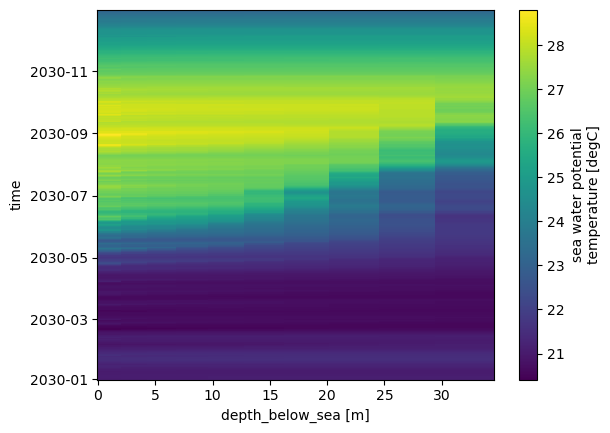

In [87]:
hovm_icon.plot()